In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, geo_tools
import glob
import gsw
import pytz

%matplotlib inline

In [2]:
f0 = pd.read_excel('/ocean/eolson/MEOPAR/obs/Hakai/Dosser20180911/2018-09-11_144804_HakaiData_nutrients.xlsx',
                 sheetname = 'Hakai Data')
f0.drop(['ACTION','Lat', 'Long', 'Collection Method', 'Installed', 'Lab Technician', 'NH4+', 'NO2+NO3 (ug/L)',
       'no2_no3_units', 'TP', 'TDP', 'TN', 'TDN', 'SRP', 'Project Specific ID', 'Hakai ID', 'Source',
       'po4pfilt', 'no3nfilt', 'po4punfl', 'no3nunfl', 'nh4nunfl', 'NH4+ Flag',
       'TP FLag', 'TDP FLag', 'TN Flag', 'TDN FLag','Volume (ml)',
       'SRP Flag', 'PO4 Flag', 'po4pfilt_flag', 'no3nfilt_flag','Preserved', 'Analyzed',
       'po4punfl_flag', 'no3nunfl_flag', 'nh4nunfl_flag', 'Analyzing Lab', 'Sample Status',
       'Quality Level', 'Comments', 'Quality Log'], axis = 1, inplace = True)
dts0=[pytz.timezone('Canada/Pacific').localize(i).astimezone(pytz.utc).replace(tzinfo=None)
        for i in f0['Collected']]
f0['dtUTC']=dts0
f0.keys()

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


Index(['no', 'event_pk', 'Replicate Number', 'Date', 'Work Area', 'Survey',
       'Sampling Bout', 'Site ID', 'Gather Lat', 'Gather Long',
       'Line Out Depth', 'Pressure Transducer Depth (m)', 'Filter Type',
       'Collected', 'NO2+NO3 (uM)', 'PO4', 'SiO2', 'NO2+NO3 Flag', 'SiO2 Flag',
       'dtUTC'],
      dtype='object')

In [3]:
f0.head()

,no,event_pk,Replicate Number,Date,Work Area,Survey,Sampling Bout,Site ID,Gather Lat,Gather Long,Line Out Depth,Pressure Transducer Depth (m),Filter Type,Collected,NO2+NO3 (uM),PO4,SiO2,NO2+NO3 Flag,SiO2 Flag,dtUTC
0,3483,4455,1,2014-11-07,QUADRA,QOMA,1,QU5,NaN,NaN,0.0,NaN,0.45nm,2014-11-07 11:30:39,17.528459,1.480,37.597988,NaN,NaN,2014-11-07 19:30:39
1,3484,4467,1,2014-11-07,QUADRA,QOMA,1,QU17,NaN,NaN,0.0,NaN,0.45nm,2014-11-07 10:30:30,19.534208,1.637,39.536296,NaN,NaN,2014-11-07 18:30:30
2,3485,4460,1,2014-11-07,QUADRA,QOMA,1,QU24,NaN,NaN,0.0,NaN,0.45nm,2014-11-07 09:30:32,20.243301,1.671,38.212329,NaN,NaN,2014-11-07 17:30:32
3,3486,4455,1,2014-11-07,QUADRA,QOMA,1,QU5,NaN,NaN,5.0,NaN,0.45nm,2014-11-07 11:30:39,19.414687,1.621,38.879558,NaN,NaN,2014-11-07 19:30:39
4,3487,4467,1,2014-11-07,QUADRA,QOMA,1,QU17,NaN,NaN,5.0,NaN,0.45nm,2014-11-07 10:30:30,19.728054,1.646,39.173135,NaN,NaN,2014-11-07 18:30:30


In [4]:
fc = pd.read_csv('/ocean/eolson/MEOPAR/obs/Hakai/Dosser20180911/ctd-bulk-1536702711696.csv',
                usecols=['Cast PK','Cruise','Station', 'Drop number','Start time', 'Bottom time',
                         'Latitude', 'Longitude', 'Depth (m)', 'Temperature (deg C)', 'Temperature flag', 'Pressure (dbar)',
                         'Pressure flag', 'PAR', 'PAR flag', 'Fluorometry Chlorophyll (ug/L)', 'Fluorometry Chlorophyll flag',
                         'Turbidity (FTU)', 'Turbidity flag',
                         'Salinity (PSU)', 'Salinity flag'],
                dtype={'Drop number':np.float64,'PAR flag':str,'Fluorometry Chlorophyll flag':str},na_values='null')

In [5]:
## fix apparent typos:
# reversed lats and lons
iii=fc['Latitude']>90
lons=-1*fc.loc[iii,'Latitude'].values
lats=-1*fc.loc[iii,'Longitude'].values
fc.loc[iii,'Longitude']=lons
fc.loc[iii,'Latitude']=lats

# remove data with missing lats and lons
nans=fc.loc[(fc['Latitude'].isnull())|(fc['Longitude'].isnull())]
fc=fc.drop(nans.index)

# apparently bad lats/lons
QU16bad=fc.loc[(fc['Station']=='QU16')&(fc['Latitude']>50.3)]
fc=fc.drop(QU16bad.index)
QU36bad=fc.loc[(fc['Station']=='QU36')&(fc['Latitude']>50.2)]
fc=fc.drop(QU36bad.index)
QU37bad=fc.loc[(fc['Station']=='QU37')&(fc['Longitude']<-125.1)]
fc=fc.drop(QU37bad.index)
QU38bad=fc.loc[(fc['Station']=='QU38')&(fc['Longitude']>-125.2)]
fc=fc.drop(QU38bad.index)
QU5bad=fc.loc[(fc['Station']=='QU5')&(fc['Longitude']>-125.18)]
fc=fc.drop(QU5bad.index)
#np.unique(fc.loc[(fc['Station']==sta)&(fc['Longitude']>-125.18)]['Cruise'].values)

In [6]:
fc.head()

,Cast PK,Cruise,Station,Drop number,Start time,Bottom time,Latitude,Longitude,Depth (m),Temperature (deg C),...,Pressure (dbar),Pressure flag,PAR,PAR flag,Fluorometry Chlorophyll (ug/L),Fluorometry Chlorophyll flag,Turbidity (FTU),Turbidity flag,Salinity (PSU),Salinity flag
0,1,QOM A,QU40,1.0,2015-11-03 12:37:20.000,2015-11-03 12:41:03.000,50.092435,-125.164387,0.991,10.6879,...,1,NaN,232.550,NaN,0.28830,NaN,0.742,NaN,28.1286,NaN
1,1,QOM A,QU40,1.0,2015-11-03 12:37:20.000,2015-11-03 12:41:03.000,50.092435,-125.164387,1.983,10.8076,...,2,NaN,146.550,NaN,0.36906,NaN,0.827,NaN,28.2369,NaN
2,1,QOM A,QU40,1.0,2015-11-03 12:37:20.000,2015-11-03 12:41:03.000,50.092435,-125.164387,2.974,10.8952,...,3,NaN,108.020,NaN,0.45831,NaN,0.742,NaN,28.3184,NaN
3,1,QOM A,QU40,1.0,2015-11-03 12:37:20.000,2015-11-03 12:41:03.000,50.092435,-125.164387,3.966,10.9617,...,4,NaN,92.601,NaN,0.49377,NaN,0.776,NaN,28.3926,NaN
4,1,QOM A,QU40,1.0,2015-11-03 12:37:20.000,2015-11-03 12:41:03.000,50.092435,-125.164387,4.957,11.0704,...,5,NaN,81.387,NaN,0.57567,NaN,0.718,NaN,28.5540,NaN


In [7]:
fc.keys()

Index(['Cast PK', 'Cruise', 'Station', 'Drop number', 'Start time',
       'Bottom time', 'Latitude', 'Longitude', 'Depth (m)',
       'Temperature (deg C)', 'Temperature flag', 'Pressure (dbar)',
       'Pressure flag', 'PAR', 'PAR flag', 'Fluorometry Chlorophyll (ug/L)',
       'Fluorometry Chlorophyll flag', 'Turbidity (FTU)', 'Turbidity flag',
       'Salinity (PSU)', 'Salinity flag'],
      dtype='object')

In [8]:
fc['dt']=[dt.datetime.strptime(i.split('.')[0],'%Y-%m-%d %H:%M:%S') for i in fc['Start time']]

In [9]:
fc['dt'][0].hour

12

In [10]:
hh=[ii.hour for ii in fc['dt']]

(array([ 2769., 11727., 26700., 68449., 86168., 83460., 67215., 37648.,
        11945.,  3597.]),
 array([ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.]),
 <a list of 10 Patch objects>)

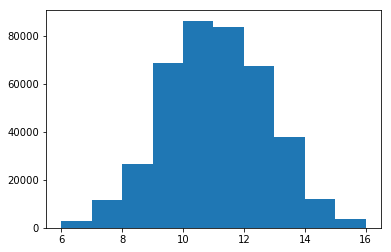

In [11]:
plt.hist(hh)
# looks like times are local vancouver time since people usually sample during daylight....

In [12]:
fc['dt']=[dt.datetime.strptime(i.split('.')[0],'%Y-%m-%d %H:%M:%S') for i in fc['Start time']]
dts=[pytz.timezone('Canada/Pacific').localize(dt.datetime.strptime(i.split('.')[0],'%Y-%m-%d %H:%M:%S')).astimezone(pytz.utc).replace(tzinfo=None)
        for i in fc['Start time']]
fc['dtUTC']=dts

In [13]:
dloc=[dt.datetime(i.year,i.month,i.day) for i in fc['dt']]
fc['dloc']=dloc

In [14]:
48/8

6.0

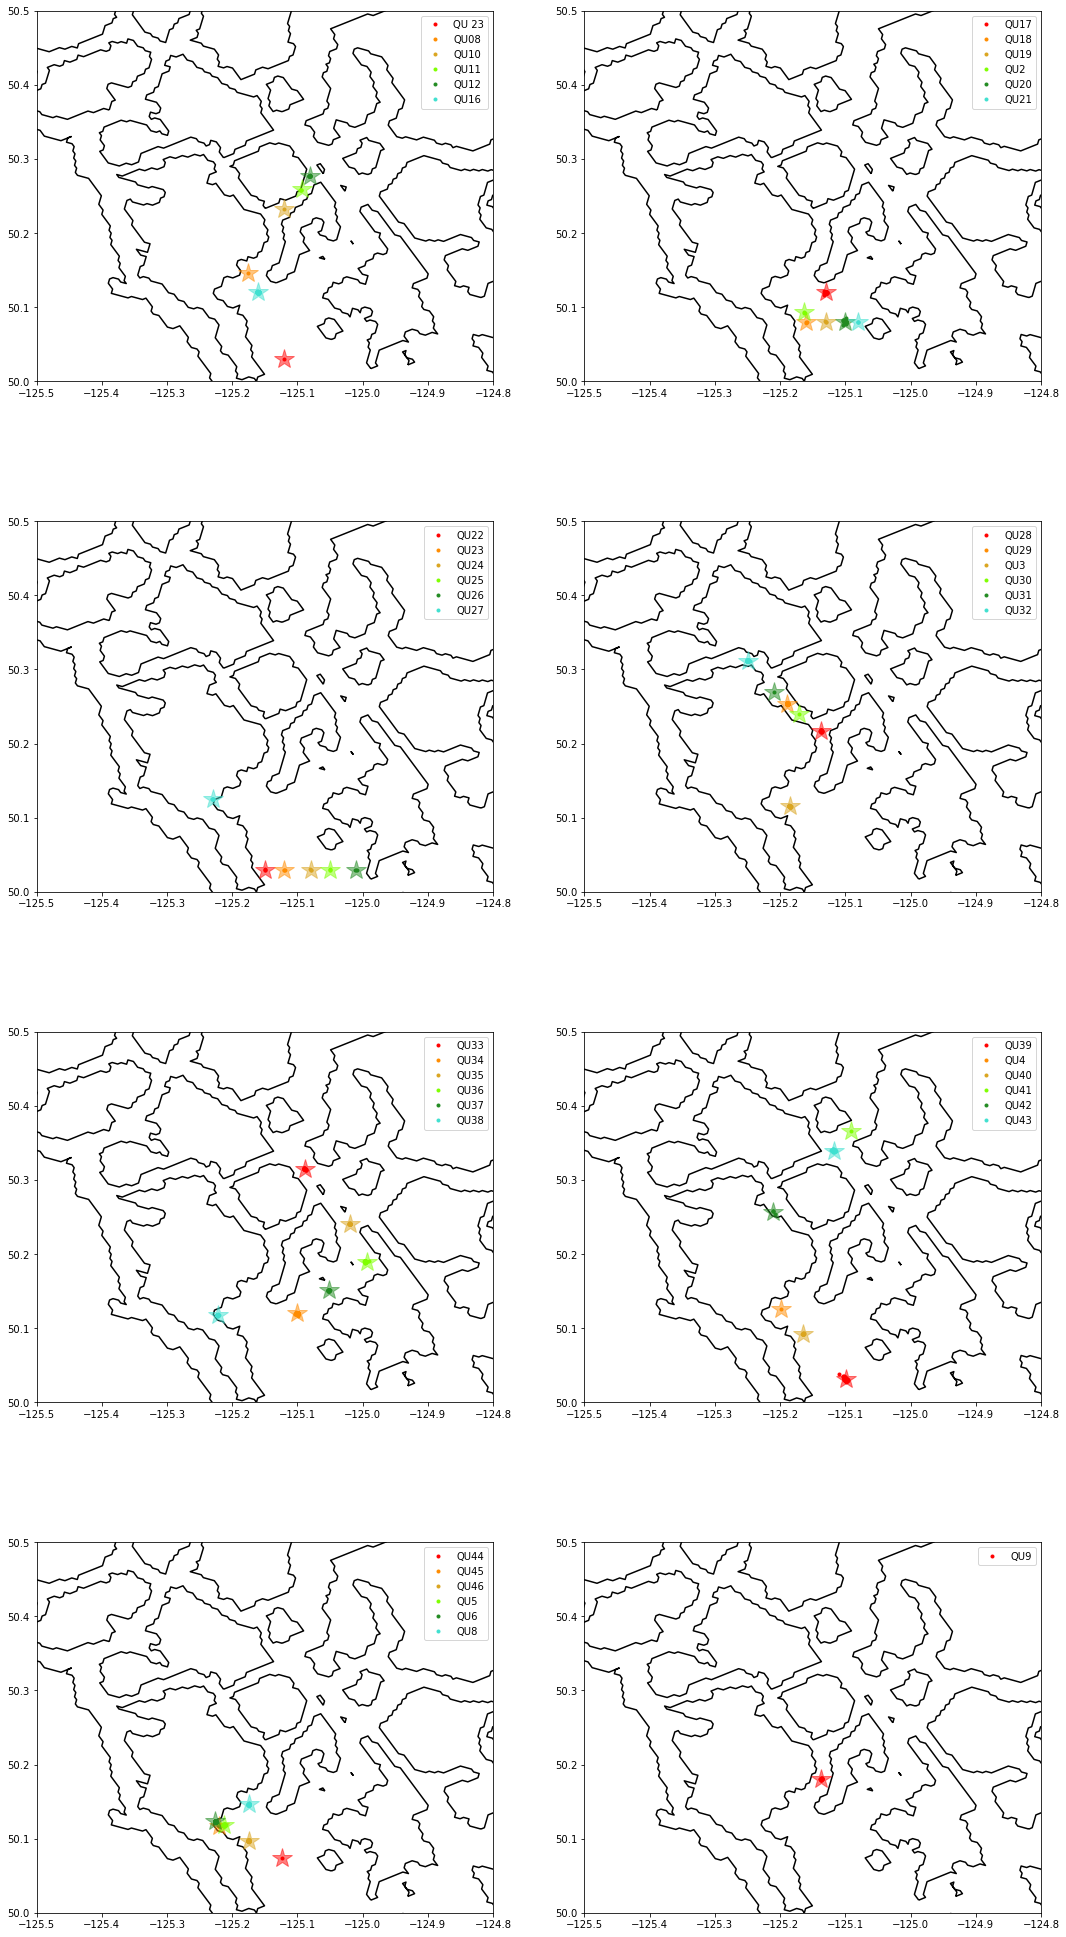

In [15]:
fig,ax=plt.subplots(4,2,figsize=(18,36))
axf=ax.flatten()
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
for axi in axf:
    viz_tools.set_aspect(axi, coords = 'map')
    viz_tools.plot_coastline(axi, grid, coords = 'map')
    axi.set_xlim(-125.5,-124.8)
    axi.set_ylim(50,50.5)

cols=['red','darkorange','goldenrod','chartreuse','forestgreen','turquoise','darkviolet']
count=0
axi=0
namelist=list()
ps=list()
for name, group in fc.groupby('Station'): 
    meanlon=np.nanmean(group['Longitude'].values)
    meanlat=np.nanmean(group['Latitude'].values)
    if count==6:
        axf[axi].legend(handles=ps)
        axi=axi+1
        count=0
        namelist=list()
        ps=list()
    # print the name of the regiment
    ll=np.unique([(i,j) for i,j in zip(group['Latitude'].values,group['Longitude'].values)],axis=0)
    for el in ll:
        p,=axf[axi].plot(el[1],el[0],'.',color=cols[count%6],label=name)
        if not name in namelist:
            namelist.append(name)
            ps.append(p)
    axf[axi].plot(meanlon,meanlat,'*',color=cols[count%6],alpha=.5,markersize=20)
    count=count+1
axf[axi].legend(handles=ps)

In [16]:
fcS=fc.loc[:,['Latitude','Longitude']].groupby([fc['Station'],fc['dloc']]).mean().reset_index()

In [17]:
fcS.head()

,Station,dloc,Latitude,Longitude
0,QU 23,2014-08-28,50.030000,-125.120000
1,QU 23,2014-10-09,50.030000,-125.120000
2,QU 23,2014-10-29,50.030000,-125.120000
3,QU08,2016-12-01,50.146282,-125.175323
4,QU10,2014-08-15,50.232300,-125.120700


In [18]:
f0['Station']=f0['Site ID']
#f0['dt']=[dt.datetime.strptime(i,'%Y-%m-%d %H:%M:%S') for i in f0['Collected']]
dloc0=[dt.datetime(i.year,i.month,i.day) for i in f0['Collected']]
f0['dloc']=dloc0

In [19]:
fdata=f0.merge(fcS,how='left')

In [20]:
len(fdata.loc[fdata['Latitude'].isnull()]),len(fdata.loc[fdata['Latitude']>=0])

(247, 3997)

In [21]:
fdata['Lat']=fdata['Latitude']
fdata['Lon']=fdata['Longitude']
fdata['Z']=fdata['Line Out Depth']

In [22]:
PATH= '/results/SalishSea/hindcast.201812/'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2016,1,1)
flen=1
namfmt='nowcast'
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T'}
fdict={'ptrc_T':1,'grid_T':1}

In [23]:
fdata2=fdata.loc[(fdata['dtUTC']>start_date)&(fdata['dtUTC']<end_date)&(fdata['Z']>=0)&(fdata['Z']<440)&(fdata['Lon']<360)&(fdata['Lat']<=90)].copy(deep=True).reset_index()

In [24]:
data=et.matchData(fdata2,filemap, fdict, start_date, end_date, namfmt, PATH, flen)

In [25]:
data.keys()

Index(['index', 'no', 'event_pk', 'Replicate Number', 'Date', 'Work Area',
       'Survey', 'Sampling Bout', 'Site ID', 'Gather Lat', 'Gather Long',
       'Line Out Depth', 'Pressure Transducer Depth (m)', 'Filter Type',
       'Collected', 'NO2+NO3 (uM)', 'PO4', 'SiO2', 'NO2+NO3 Flag', 'SiO2 Flag',
       'dtUTC', 'Station', 'dloc', 'Latitude', 'Longitude', 'Lat', 'Lon', 'Z',
       'j', 'i', 'mod_nitrate', 'mod_silicon', 'mod_ammonium', 'mod_diatoms',
       'mod_ciliates', 'mod_flagellates'],
      dtype='object')

## Nitrate

In [26]:
N_s, modmean_s, obsmean_s, bias_s, RMSE_s, WSS_s = et.stats(data.loc[data.Z<15,['NO2+NO3 (uM)']],data.loc[data.Z<15,['mod_nitrate']])
N_i, modmean_i, obsmean_i, bias_i, RMSE_i, WSS_i = et.stats(data.loc[(data.Z>=15)&(data.Z<22),['NO2+NO3 (uM)']],data.loc[(data.Z>=15)&(data.Z<22),['mod_nitrate']])
N_d, modmean_d, obsmean_d, bias_d, RMSE_d, WSS_d = et.stats(data.loc[data.Z>=22,['NO2+NO3 (uM)']],data.loc[data.Z>=22,['mod_nitrate']])
N, modmean, obsmean, bias, RMSE, WSS = et.stats(data.loc[:,['NO2+NO3 (uM)']],data.loc[:,['mod_nitrate']])
print('Nitrate')
print('z<15 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_s,bias_s,RMSE_s,WSS_s))
print('15 m<=z<22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_i,bias_i,RMSE_i,WSS_i))
print('z>=22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d,bias_d,RMSE_d,WSS_d))
print('all:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N,bias,RMSE,WSS))

Nitrate
z<15 m:
  N: 812
  bias: -1.854515565061492
  RMSE: 5.697454369194201
  WSS: 0.8934122324155607
15 m<=z<22 m:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
z>=22 m:
  N: 449
  bias: -2.706079959447397
  RMSE: 3.75335873321218
  WSS: 0.8398968039567892
all:
  N: 1261
  bias: -2.157729215401911
  RMSE: 5.091058150288503
  WSS: 0.9325113095298656


/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/eolson/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:779: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/eolson/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:780: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)


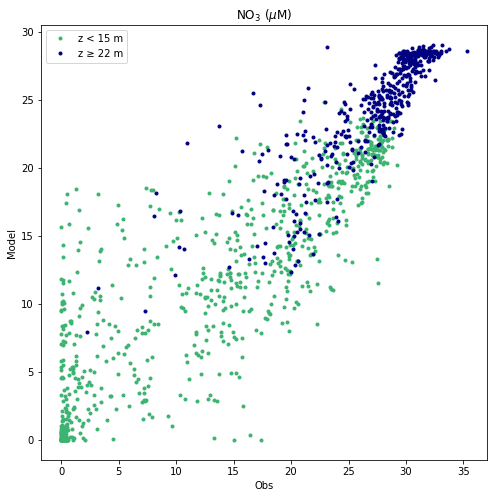

In [27]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'NO2+NO3 (uM)','mod_nitrate','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')

Nitrate, z<15
Feb-Mar:
  N: 161
  bias: -2.8333191294821667
  RMSE: 5.817212366542223
  WSS: 0.852101347194446
April:
  N: 97
  bias: -0.9463848623450888
  RMSE: 5.645529195133124
  WSS: 0.7900625976298907
May-Jun:
  N: 296
  bias: -0.09259615718785419
  RMSE: 5.608329353722579
  WSS: 0.8478239163949477
Sep-Oct:
  N: 216
  bias: -3.156973728288474
  RMSE: 5.674136593046056
  WSS: 0.8011586266174263


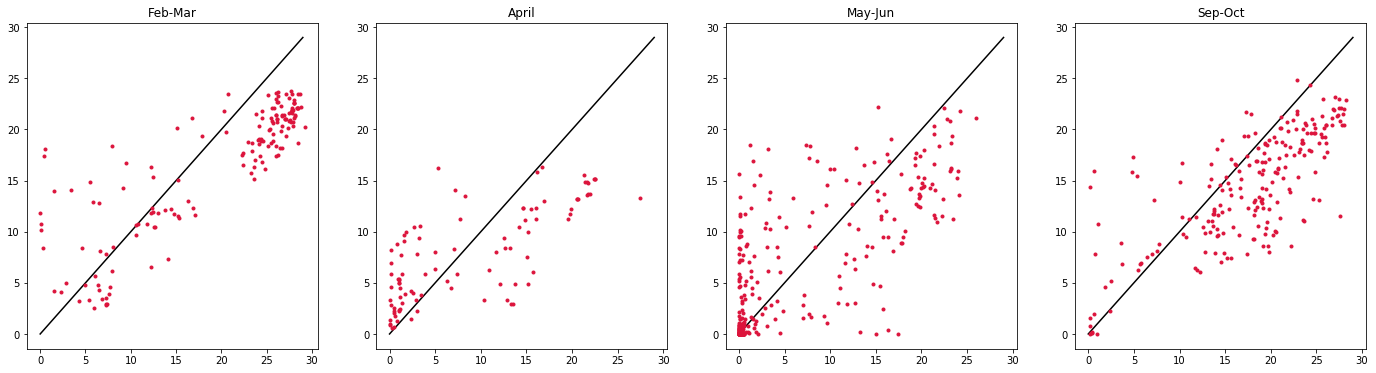

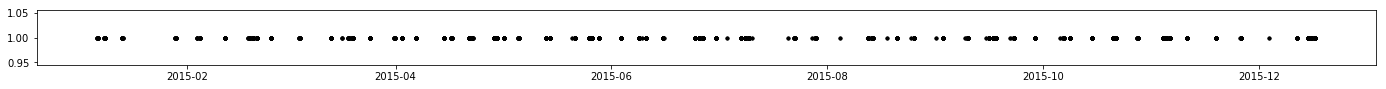

In [28]:
nvar='NO2+NO3 (uM)'
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,30),np.arange(0,30),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2015,4,1)),:],nvar,'mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,5,1))&(data.dtUTC>dt.datetime(2015,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],nvar,'mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,9,1))&(data.dtUTC>dt.datetime(2015,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],nvar,'mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,12,1))&(data.dtUTC>dt.datetime(2015,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],nvar,'mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

print('Nitrate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2015,4,1)),:],nvar,'mod_nitrate')
print('April:')
et.printstats(data.loc[ii1,:],nvar,'mod_nitrate')
print('May-Jun:')
et.printstats(data.loc[ii2,:],nvar,'mod_nitrate')
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],nvar,'mod_nitrate')
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

In [29]:
sivar='SiO2'

(-40, 20)

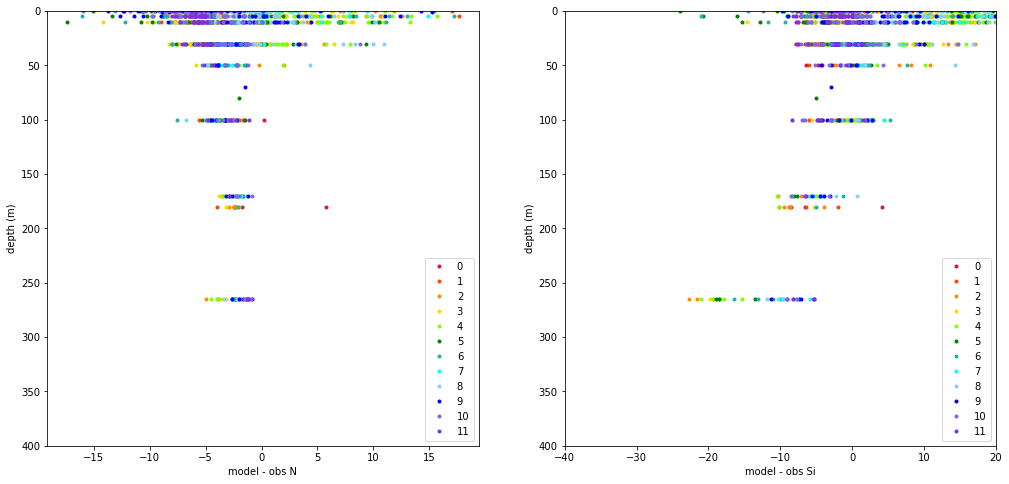

In [30]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
cols=('crimson','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'lightskyblue','blue','mediumslateblue','blueviolet','darkmagenta','fuchsia')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,[nvar]].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,[sivar]].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('model - obs N')
ax[1].set_xlabel('model - obs Si')
ax[1].set_xlim(-40,20)

## Silicate

In [31]:
print('Nitrate')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],sivar,'mod_silicon')
print('15 m<=z<22 m:')
et.printstats(data.loc[(data.Z>=15)&(data.Z<22),:],sivar,'mod_silicon')
print('z>=22 m:')
et.printstats(data.loc[data.Z>=22,:],sivar,'mod_silicon')
print('all:')
et.printstats(data,sivar,'mod_silicon')


Nitrate
z<15 m:
  N: 775
  bias: 6.729059452275855
  RMSE: 12.471388598021257
  WSS: 0.8181368667333759
15 m<=z<22 m:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
z>=22 m:
  N: 449
  bias: -0.9358527567124852
  RMSE: 6.583932797588146
  WSS: 0.7868349026182254
all:
  N: 1224
  bias: 3.9173392056780187
  RMSE: 10.694944415560078
  WSS: 0.8652308317077452


/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/eolson/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:779: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/eolson/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:780: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)


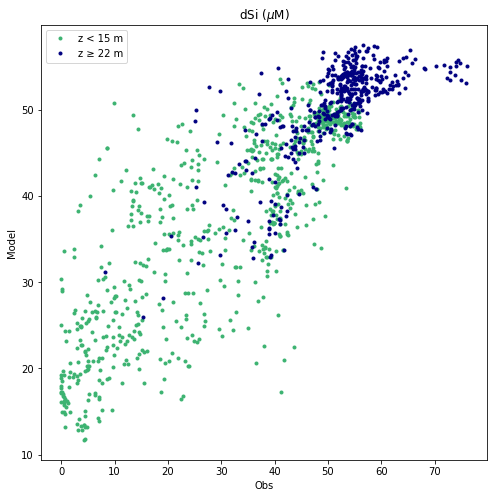

In [32]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,sivar,'mod_silicon','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('dSi ($\mu$M)')

Silicate, z<15
Feb-Mar:
  N: 161
  bias: 5.267393961164132
  RMSE: 11.217587806851492
  WSS: 0.8173034986228207
April:
  N: 97
  bias: 5.9823962108912845
  RMSE: 10.563510749935423
  WSS: 0.7321244805732761
May-Jun:
  N: 284
  bias: 10.032949682278574
  RMSE: 15.373866933993389
  WSS: 0.7092378524061604
Sep-Oct:
  N: 195
  bias: 5.3109466028727965
  RMSE: 10.576040218210322
  WSS: 0.45724951487775145


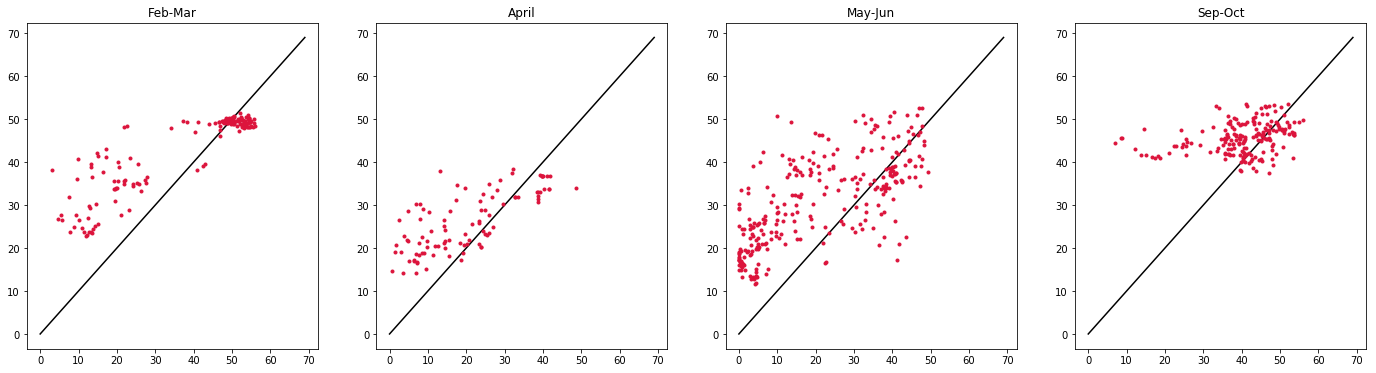

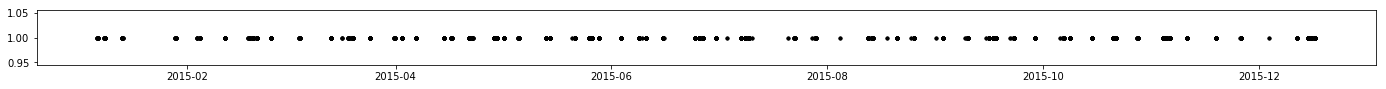

In [33]:
obsvar=sivar; modvar='mod_silicon'
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,70),np.arange(0,70),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2015,4,1)),:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,5,1))&(data.dtUTC>dt.datetime(2015,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,9,1))&(data.dtUTC>dt.datetime(2015,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,12,1))&(data.dtUTC>dt.datetime(2015,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

print('Silicate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2015,4,1)),:],obsvar,modvar)
print('April:')
et.printstats(data.loc[ii1,:],obsvar,modvar)
print('May-Jun:')
et.printstats(data.loc[ii2,:],obsvar,modvar)
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],obsvar,modvar)
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

## Ratios

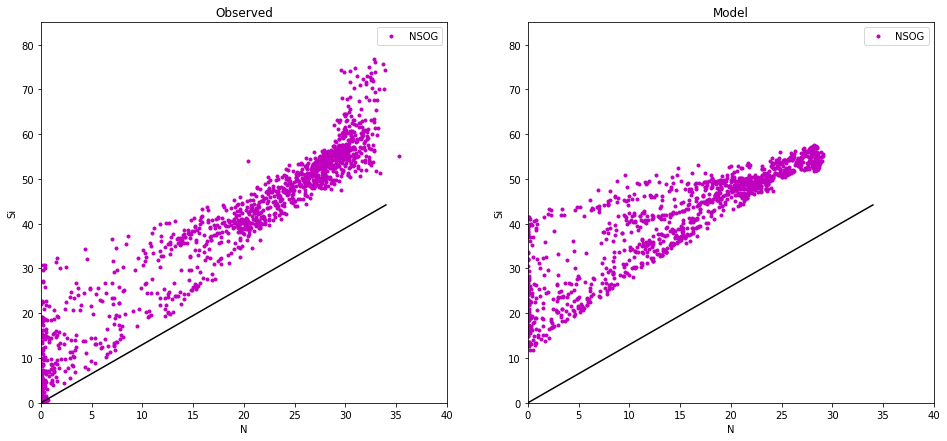

In [34]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p4=ax[0].plot(data[nvar],data[sivar],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Si')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p8=ax[1].plot(data['mod_nitrate'],data['mod_silicon'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Si')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')